In [1]:
import time
import random
import numpy as np
import pandas as pd
import sys
import pickle
import h5py
import copy
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import learn2learn as l2l
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from functions.fftc import fft2c_new as fft2c
from functions.fftc import ifft2c_new as ifft2c
from functions.math import complex_abs, complex_mul, complex_conj
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_TTTpaper_fixMask, center_crop, scale_sensmap, normalize_separate_over_ch, rss_torch
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss
from functions.helper import evaluate2c_imagepair
### after you install bart 0.7.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/cheng/bart-0.7.00/python/')
os.environ['TOOLBOX_PATH'] = "/cheng/bart-0.7.00/"
import bart


plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

colors = ['b','r','k','g','m','c','tab:brown','tab:orange','tab:pink','tab:gray','tab:olive','tab:purple']

markers = ["v","o","^","1","*",">","d","<","s","P","X"]
FONTSIZE = 22

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# seed
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)


### Load the data

In [2]:
# data path
path_test = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_brain_val.yaml'
path_test_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_brain_val/'

# path_test = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_brain_test_100.yaml'
# path_test_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_brain_test/'

# data transform
data_transform = UnetDataTransform_TTTpaper_fixMask('multicoil')

# training dataset and data loader
testset = SliceDataset(dataset = path_test, path_to_dataset='', 
                path_to_sensmaps = path_test_sensmaps, provide_senmaps=True, 
                challenge="multicoil", transform = data_transform, use_dataset_cache=True)

# shuffle = False !!!!!!!
test_dataloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1, 
                shuffle = False, generator = torch.Generator().manual_seed(1), pin_memory = False)


In [3]:
checkpoint_path = '/cheng/metaMRI/metaMRI/save/E_tttkspace_sensmap_joint(l1_1e-5)P_T300_300epoch/E_tttkspace_sensmap_joint(l1_1e-5)P_T300_300epoch_E300.pth'

model = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

In [4]:
path_mask = '/cheng/metaMRI/ttt_for_deep_learning_cs/unet/test_data/anatomy_shift/mask2d'
with open(path_mask,'rb') as fn:
    mask2d = pickle.load(fn)
mask = torch.tensor(mask2d[0]).unsqueeze(0).unsqueeze(0).unsqueeze(-1)
mask = mask.to(device)

### Test-time training

In [5]:
background_flip = True
eval_with_binary_mask = False

Sensmap

In [6]:
# best_loss_l1_history=[]
# best_loss_l1_index_history=[]
best_loss_ssim_history=[]
best_loss_ssim_index_history=[]
ssim_fct = SSIMLoss()
l1_loss = torch.nn.L1Loss(reduction='sum')
adapt_lr = 0.00001
TTT_epoch = 500
# each data point TTT

for iter, batch in enumerate(test_dataloader): 
    print('Testing sample: ', iter+1)
    origk, sens_maps, sens_maps_conj, binary_background_mask, fname, slice_num = batch
    origk = origk.squeeze(0).to(device)
    sens_maps = sens_maps.squeeze(0).to(device)
    sens_maps_conj = sens_maps_conj.squeeze(0).to(device)
    binary_background_mask = binary_background_mask.to(device)

    # input k space
    input_kspace = origk * mask + 0.0
    # scale factor
    scale_factor = scale_sensmap(input_kspace, model,sens_maps_conj)
    scale_input_kspace = scale_factor * input_kspace # [coils,height,width,2]

    # gt image by normalized kspace: x
    target_image_1c = complex_abs(complex_mul(ifft2c(origk * scale_factor), sens_maps_conj).sum(dim=0, keepdim=False)).unsqueeze(0)
    # sensmap combine
    # target_image = complex_mul(target_image, sens_maps_conj).sum(dim=0, keepdim=False)
    crop_size = torch.Size([min(target_image_1c.shape[-2:]), min(target_image_1c.shape[-2:])])
    crop_target_image = center_crop( target_image_1c, crop_size )
    std_crop_target_image = crop_target_image.std()
    mean_crop_target_image = crop_target_image.mean()

    # A†y
    # train_inputs = complex_mul(train_inputs, sens_maps_conj).sum(dim=0, keepdim=False) #shape: height,width,2
    train_inputs = complex_mul(ifft2c(scale_input_kspace), sens_maps_conj).sum(dim=0, keepdim=False)
    train_inputs = torch.moveaxis( train_inputs , -1, 0 )

    loss_l1_history = []
    loss_ssim_history = []
    self_loss_history = []
    model_ttt = copy.deepcopy(model)
    optimizer = torch.optim.Adam(model_ttt.parameters(),lr=adapt_lr)

    for iteration in range(TTT_epoch): 
        ###### training ######
        # fθ(A†y)
        model_output = model_ttt(train_inputs.unsqueeze(0))    # [1, 2, height, width]       
        model_output = torch.moveaxis(model_output, 1, -1 )    #[1, height, width, 2]
        # S fθ(A†y) [coils, height, width, channel]
        if background_flip == True: 
            output_sens_image = torch.zeros(sens_maps.shape).to(device) 
            for j,s in enumerate(sens_maps):
                ss = s.clone()
                ss[torch.abs(ss)==0.0] = torch.abs(ss).max()
                output_sens_image[j,:,:,0] = model_output[0,:,:,0] * ss[:,:,0] - model_output[0,:,:,1] * ss[:,:,1]
                output_sens_image[j,:,:,1] = model_output[0,:,:,0] * ss[:,:,1] + model_output[0,:,:,1] * ss[:,:,0]

        else: 
            output_sens_image = complex_mul(model_output, sens_maps)
        # FS fθ(A†y)
        Fimg = fft2c(output_sens_image)
        # MFS fθ(A†y) = A fθ(A†y)
        Fimg_forward = Fimg * mask
        # consistency loss [y, Afθ(A†y)]
        loss_self = l1_loss(Fimg_forward, scale_input_kspace) / torch.sum(torch.abs(scale_input_kspace))

        optimizer.zero_grad()
        loss_self.backward()
        optimizer.step()
        #train_loss += loss.item()
        #print('TTT loss: ',loss_self.item())
        self_loss_history.append(loss_self.item())

        ###### evaluation ######
        output_image_1c = complex_abs(model_output).unsqueeze(0)    # [2, height, width] -> [1, height, width]
        if eval_with_binary_mask == True: 
            binary_mask_output_image_1c = (output_image_1c.unsqueeze(0) * binary_background_mask).squeeze(0)
            # center crop for SSIM
            crop_output_image = center_crop( binary_mask_output_image_1c, crop_size )
        else: 
            # center crop for SSIM
            crop_output_image = center_crop( output_image_1c, crop_size )
        # normalization
        crop_output_image = (crop_output_image - crop_output_image.mean()) / crop_output_image.std()
        crop_output_image *= std_crop_target_image
        crop_output_image += mean_crop_target_image
        # SSIM = 1 - loss
        loss_ssim = 1 - ssim_fct(crop_output_image, crop_target_image, data_range = crop_target_image.max().unsqueeze(0)).item()
        print(f"Epoch {iteration+1}/{TTT_epoch}, Loss: {loss_self.item():.4f}", end='\r')
        print(f"Epoch {iteration+1}/{TTT_epoch}, SSIM: {loss_ssim:.4f}", end='\r')

        #loss_l1_history.append(loss_l1)
        loss_ssim_history.append(loss_ssim)

    # best results for an example
    # best_loss_l1 = min(loss_l1_history)
    # print('The best L1: ', best_loss_l1)
    # best_loss_l1_epoch = np.argmin(loss_l1_history)
    # print('The best L1 epoch: ', best_loss_l1_epoch)
    best_loss_ssim = max(loss_ssim_history)
    print('The best SSIM through training process:', best_loss_ssim)
    best_loss_ssim_epoch = np.argmax(loss_ssim_history)
    print('The best SSIM epoch: ', best_loss_ssim_epoch)

    # best_loss_l1_index_history.append(best_loss_l1_epoch)
    best_loss_ssim_index_history.append(best_loss_ssim_epoch)
    # best_loss_l1_history.append(best_loss_l1)
    best_loss_ssim_history.append(best_loss_ssim)


# print("Testing average L1 loss: ", sum(best_loss_l1_history) / len(best_loss_l1_history))
# print("Testing average L1 loss epoch: ", sum(best_loss_l1_index_history) / len(best_loss_l1_index_history))
print("Testing average SSIM loss: ", sum(best_loss_ssim_history) / len(best_loss_ssim_history))
print("Testing average SSIM loss epoch: ", sum(best_loss_ssim_index_history) / len(best_loss_ssim_index_history))

Testing sample:  1
The best SSIM through training process: 0.9471363425254822
The best SSIM epoch:  152
Testing sample:  2
The best SSIM through training process: 0.9168296456336975
The best SSIM epoch:  160
Testing sample:  3
The best SSIM through training process: 0.937630295753479
The best SSIM epoch:  112
Testing sample:  4
The best SSIM through training process: 0.9379016757011414
The best SSIM epoch:  171
Testing sample:  5
The best SSIM through training process: 0.9454979300498962
The best SSIM epoch:  204
Testing sample:  6
The best SSIM through training process: 0.9359585642814636
The best SSIM epoch:  131
Testing sample:  7
The best SSIM through training process: 0.938298225402832
The best SSIM epoch:  218
Testing sample:  8
The best SSIM through training process: 0.9266636371612549
The best SSIM epoch:  81
Testing sample:  9
The best SSIM through training process: 0.939936637878418
The best SSIM epoch:  175
Testing sample:  10
The best SSIM through training process: 0.937684

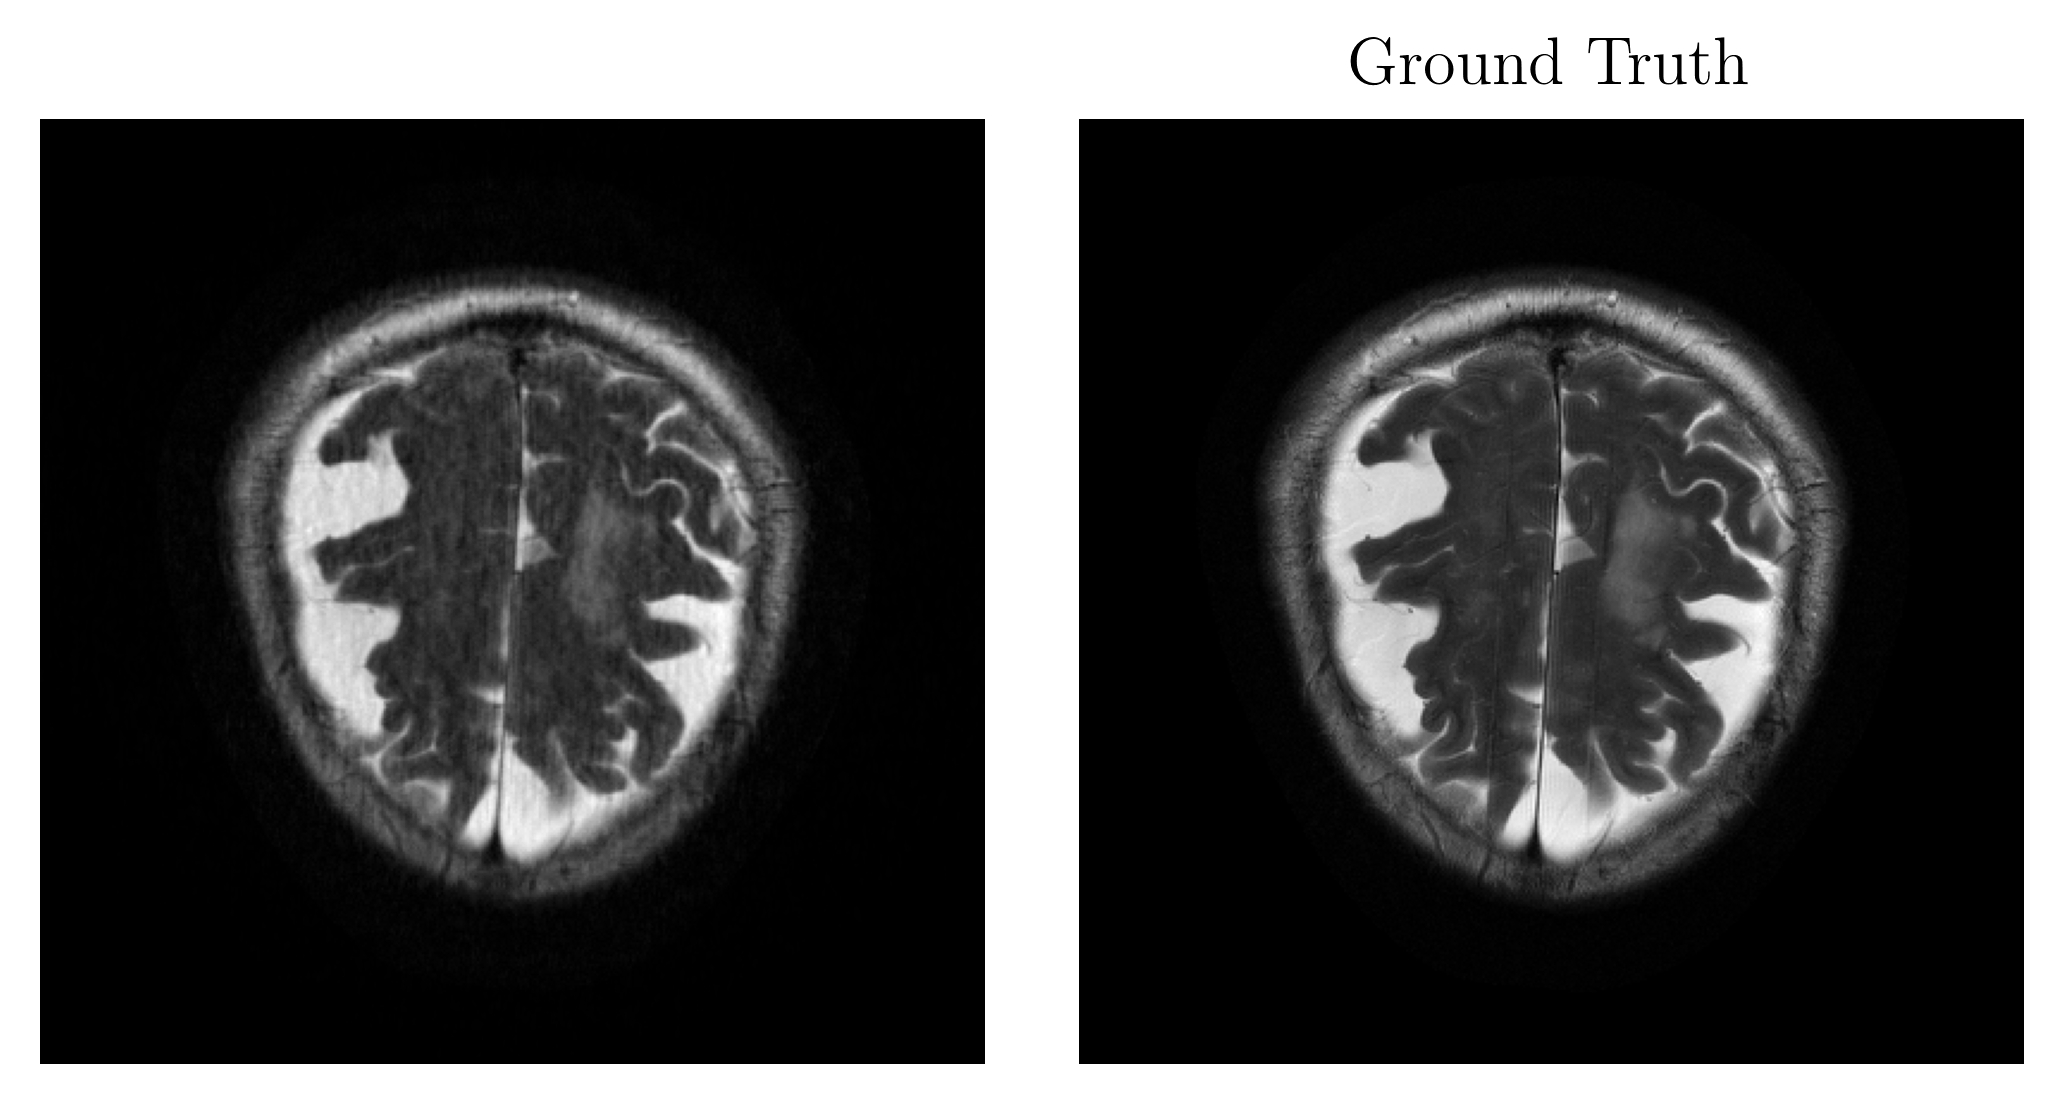

In [7]:
fig, axes = plt.subplots(1, 2, dpi= 400)

axes[0].imshow(crop_output_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[0].axis('off')

axes[1].imshow(crop_target_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[1].set_title('Ground Truth')
axes[1].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()

without TTT

In [8]:
COIL = 'sensmap'
gt_norm = True

loss_ssim_history_=[]
ssim_fct = SSIMLoss()
l1_loss = torch.nn.L1Loss(reduction='sum')

for iter, batch in tqdm(enumerate(test_dataloader)): 
    kspace, sens_maps, sens_maps_conj, _, fname, slice_num = batch
    kspace = kspace.squeeze(0).to(device)
    sens_maps = sens_maps.squeeze(0).to(device)
    sens_maps_conj = sens_maps_conj.squeeze(0).to(device)

    # input k space
    input_kspace = kspace * mask + 0.0

    # scale factor
    scale_factor = scale_sensmap(input_kspace, model,sens_maps_conj)

    # gt image: x
    if COIL == 'rss':
        target_image_1c = rss_torch(complex_abs(ifft2c(kspace * scale_factor))).unsqueeze(0)
    elif COIL == 'sensmap':
        target_image_1c = complex_abs(complex_mul(ifft2c(kspace * scale_factor), sens_maps_conj).sum(dim=0, keepdim=False)).unsqueeze(0)
    # center crop for SSIM
    crop_size = torch.Size([min(target_image_1c.shape[-2:]), min(target_image_1c.shape[-2:])])
    crop_target_image = center_crop( target_image_1c, crop_size )
    if gt_norm: 
        std_crop_target_image = crop_target_image.std()
        mean_crop_target_image = crop_target_image.mean()

    # A†y
    scale_input_kspace = scale_factor* input_kspace
    if COIL == 'rss':
        train_inputs = rss_torch(ifft2c(scale_input_kspace))
    elif COIL == 'sensmap':    
        train_inputs = complex_mul(ifft2c(scale_input_kspace), sens_maps_conj).sum(dim=0, keepdim=False)
    # [height, width, 2]
    train_inputs = torch.moveaxis( train_inputs , -1, 0 ) # move complex channels to channel dimension
    # [2, height, width]

    # fθ(A†y)
    train_outputs = model(train_inputs.unsqueeze(0)) # [1, 2, height, width]
    train_outputs_1c = complex_abs(torch.moveaxis(train_outputs.squeeze(0), 0, -1 )).unsqueeze(0) # [1, height, width]

    # center crop for SSIM
    crop_output_image = center_crop( train_outputs_1c, crop_size )
    # normalization
    if gt_norm: 
        crop_output_image = (crop_output_image - crop_output_image.mean()) / crop_output_image.std()
        crop_output_image *= std_crop_target_image
        crop_output_image += mean_crop_target_image


    # loss_ssim = 1 - ssim_fct(binary_mask_output_image_1c, crop_target_image, data_range = crop_target_image.max().unsqueeze(0)).item()
    loss_ssim = 1 - ssim_fct(crop_output_image, crop_target_image, data_range = crop_target_image.max().unsqueeze(0)).item()

    # loss_l1_history_.append(loss_l1)
    loss_ssim_history_.append(loss_ssim)

100it [00:53,  1.87it/s]


In [9]:
# print("Testing average L1 loss: ", sum(loss_l1_history_) / len(loss_l1_history_))
print("Testing average SSIM loss: ", sum(loss_ssim_history_) / len(loss_ssim_history_))

Testing average SSIM loss:  0.7747853589057923
